In [1]:
# This is lzl's snippet for diploma project
import math
import os,shutil
import random
import warnings
import gc

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import seaborn as sns
from shapely.geometry import LineString, Point, Polygon
from shapely.wkt import dumps, loads
from tqdm import tqdm
tqdm.pandas(desc='pandas bar')

import traProject as tp
from traProject.analysisFuns import statisticFuns as sfuns
from traProject.basicFuns import CalFuns as cfun,VisFuns as vfun,DataProcessingFuns as dfun
from traProject.classificationFuns import model_feature_selection as mfs
import traProject.utils as tu

random.seed(1229)

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

warnings.filterwarnings("ignore")



# 基础预处理（彩丽&凤伟师姐、barefoot）

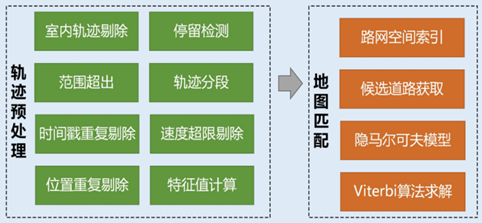

# 时间戳问题

[时间戳问题排查](时间戳问题排查.ipynb)  
解决方案：  
认为除了异常数据外时间戳的正确性，筛选2019.07至2019.09全部数据

In [6]:
tra_all=tu.calDate('../../output/tmp/武汉轨迹all_merged/tra_all.csv',calList=['day','hour','month'],timestr=False)
t_filter=tu.timespan2unix(['2019-07-01 00:00:00','2019-09-30 23:59:59'])
tra_f=tra_all[(tra_all.timestamp>=t_filter[0])&(tra_all.timestamp<=t_filter[1])]
tra_f.to_csv(tu.pathCheck('../../output/paper/wuhan_all/')+'tra_all_789.csv',index=0)

In [16]:
cnames=['pid','roadid','timestamp','lat_old','lon_old','bearing','speed','bearing1','speed_cal','lat','lon','fid']
tra_all=pd.read_csv('../../output/paper/wuhan_all/tra_all1.csv')

In [6]:
tra_all=tu.calDate('../../output/paper/wuhan_all/tra_all1.csv',calList=['day','hour','month'],timestr=False)
t_filter=tu.timespan2unix(['2019-07-01 00:00:00','2019-09-30 23:59:59'])
tra_f=tra_all[(tra_all.timestamp>=t_filter[0])&(tra_all.timestamp<=t_filter[1])]
tra_f.to_csv(tu.pathCheck('../../output/paper/wuhan_all/')+'tra_all1_789.csv',index=0)

# 速度计算实验

## 数据读取

In [7]:
data_all=pd.read_csv('../../output/paper/wuhan_all/tra_all_789.csv')
data_all1=pd.read_csv('../../output/paper/wuhan_all/tra_all1_789.csv')

<AxesSubplot:xlabel='hour', ylabel='speed'>

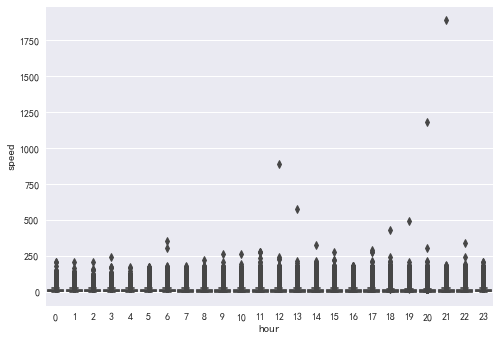

In [5]:
sns.boxplot(data_all['hour'],data_all['speed'])

## 利用经纬度和时间戳计算速度，为后续方案测试准备

In [8]:
data_all=pd.read_csv('../../output/paper/wuhan_all/tra_all_789.csv')
data_all

,pid,tid,roadid,fid,lon,lat,timestamp,speed,type,acc,bearing,heading,hour,month,day
0,0,154,751207790,0,114.609812,30.496618,1564384134,0.0,0,4,0.0,1,15,7,29
1,1,154,751207790,0,114.609812,30.496618,1564384173,6.0,0,14,299.0,1,15,7,29
2,2,154,751207790,0,114.609484,30.496833,1564384178,9.0,0,13,306.0,1,15,7,29
3,0,124,105737895,1,114.390502,30.636499,1564357343,0.0,0,17,39.0,1,7,7,29
4,1,124,105737895,1,114.390502,30.636499,1564357348,0.0,0,8,0.0,1,7,7,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103949,0,1739,66527024,1848455,114.403232,30.461618,1564066526,5.0,1,30,251.0,1,22,7,25
18103950,1,1739,66527024,1848455,114.403058,30.461722,1564066529,0.0,0,25,0.0,0,22,7,25
18103951,2,1739,66527024,1848455,114.403156,30.461664,1564066533,1.0,0,18,350.0,0,22,7,25
18103952,3,1739,103496300,1848455,114.403400,30.459671,1564066551,1.0,0,9,230.0,0,22,7,25


In [2]:
data_all=pd.read_csv('../../output/paper/wuhan_all/tra_all1_789.csv')
# data_all=data_all[data_all.type==0]
# data_all.reset_index(drop=True,inplace=True)
data_all=cfun.calV(data_all,vname='velocity',calvfun=1,by='fid')#计算速度
data_all.speed*=3.6
data_all.to_csv('../../output/paper/velocity/tra_all1_v0.csv',index=0)

my bar!: 100%|████████████████████████████████████████████████████████████| 18103954/18103954 [14:28<00:00, 20847.23it/s]


In [3]:
data_all=pd.read_csv('../../output/paper/wuhan_all/tra_all1_789.csv')
# data_all=data_all[data_all.type==0]
# data_all.reset_index(drop=True,inplace=True)
data_all=cfun.calV(data_all,vname='velocity',calvfun=2,by='fid')#计算速度
data_all.speed*=3.6
data_all.to_csv('../../output/paper/velocity/tra_all1_v1.csv',index=0)

my bar!: 100%|████████████████████████████████████████████████████████████| 18103954/18103954 [18:19<00:00, 16470.27it/s]


In [4]:
v0=pd.read_csv('../../output/paper/velocity/tra_all1_v0.csv')
v1=pd.read_csv('../../output/paper/velocity/tra_all1_v1.csv')
v0['velocity1']=v1['velocity']
v0.to_csv('../../output/paper/velocity/tra_all1.csv',index=0)

## 两点计算速度or三点计算？

In [2]:
v0=pd.read_csv('../../output/paper/velocity/tra_all.csv')

In [3]:
test1=v0[v0.velocity>0]
test2=v0[v0.velocity1>0]

In [10]:
originlen=len(v0)
print('原始总点数:%s'%originlen)
print('两点计算点数量:{}(总点数的{:.2f}%),与speed字段的MAE={}'.format(len(test1),len(test1)/originlen*100,abs(test1.speed-test1.velocity).mean()))
print('三点计算点数量:{}(总点数的{:.2f}%),与speed字段的MAE={}'.format(len(test2),len(test2)/originlen*100,abs(test2.speed-test2.velocity1).mean()))

原始总点数:18103954
两点计算点数量:15852956(总点数的87.57%),与speed字段的MAE=12.372182423355746
三点计算点数量:14377031(总点数的79.41%),与speed字段的MAE=9.96342570487768


## 按OSM_id分组

In [2]:
road_all=pd.read_csv('../../output/paper/wuhan_road/WUHAN_new.csv')
data_all=pd.read_csv('../../output/paper/velocity/tra_all.csv')
#按osmid分组输出文件，减轻后续计算负担
# data_all.drop(['heading'],axis=1,inplace=True)
rlist=road_all.osm_id.unique().tolist()
for rid in tqdm(rlist):
    tmp=data_all[data_all.roadid==rid]
    if len(tmp)==0:
        continue
    tmp.drop(['roadid'],axis=1,inplace=True)#TODO
    tmp.to_csv(tu.pathCheck('../../output/paper/tra_osmid/')+'%s.csv'%rid,index=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1327/1327 [03:25<00:00,  6.46it/s]


## 按link_id分组再合并（用于打标签+分析异常）

In [5]:
cfun.calV_link_aux(
        roadpath='../../output/paper/wuhan_road/WUHAN_new.csv',
        trapath='../../output/paper/velocity/tra_all1.csv',
        bufR=0.00002,
        filename='new',
        outfile=tu.pathCheck('../../output/paper/tra_linkid_aux/')
        )

100%|████████████████████████████████████████████████████████████████████████████████| 3684/3684 [19:23<00:00,  3.16it/s]


In [7]:
test=pd.read_csv('../../output/paper/tra_linkid_aux/newbufR=2e-05.csv',nrows=10000)
test

,pid,timestamp,lat_old,lon_old,bearing,speed,bearing1,speed_cal,lat,lon,fid,hour,month,day,velocity,velocity1,maxspeed,link_id
0,9,1563092993,30.578505,114.262028,59.0,32.4,63.90,5.05,30.578585,114.262064,8217,16,7,14,24.169270,20.414795,40,28833560-1
1,8,1564062688,30.578500,114.262028,59.0,28.8,56.98,8.50,30.578585,114.262064,9376,21,7,25,82.414473,66.371856,40,28833560-1
2,2,1563785877,30.579029,114.263042,0.0,0.0,62.68,0.00,30.579055,114.263025,10650,16,7,22,15.466510,-9999.000000,40,28833560-1
3,12,1564113719,30.579073,114.263172,156.0,39.6,152.23,11.81,30.579063,114.263148,11289,12,7,26,36.951055,43.631117,40,28833560-1
4,0,1564114161,30.579045,114.263248,0.0,0.0,0.00,0.00,30.579023,114.263168,12167,12,7,26,-9999.000000,-9999.000000,40,28833560-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,1563840388,30.575699,114.248480,0.0,14.4,172.47,4.39,30.574523,114.248343,227780,8,7,23,0.000000,0.000000,40,28833560-7
9996,5,1563840391,30.575588,114.248437,0.0,14.4,198.30,3.57,30.574523,114.248343,227780,8,7,23,0.000000,0.000000,40,28833560-7
9997,6,1563840396,30.575458,114.248380,198.0,10.8,200.91,2.14,30.574523,114.248343,227780,8,7,23,0.000000,0.000000,40,28833560-7
9998,7,1563840403,30.575358,114.248418,184.0,3.6,161.68,2.26,30.574523,114.248343,227780,8,7,23,0.000000,0.000000,40,28833560-7


In [5]:
test=pd.read_csv('../../output/paper/tra_linkid_aux/newbufR=2e-05.csv',nrows=10000)
test.to_csv('../../output/paper/test.csv',index=0)

## 新算法封装测试

In [4]:
for vname in ['velocity','velocity1']:
    for v in [0,2]:
        cfun.calV_link_v1(roadpath='../../output/paper/wuhan_road/WUHAN_new.csv', 
              trapath='../../output/paper/tra_linkid_aux/bufR=2e-05.csv', 
              version=v, 
              minN=50, 
              dropWifi=False, 
              filename='tra_link_id_v',
              wfilename='problem_road',
              outfile=tu.pathCheck('../../output/paper/tra_linkid1/'),
              velocityName=vname)

100%|███████████████████████████████████████████████████████████████████████████████| 3548/3548 [00:33<00:00, 105.28it/s]


## 方案测试算法封装

In [2]:
for vname in ['velocity','velocity1']:
    for v in [0,2]:
        cfun.calV_link(roadpath='../../output/paper/wuhan_road/WUHAN_new.csv', 
              osmpath='../../output/paper/tra_osmid/', 
              version=v, 
              bufR=3e-05, 
              minN=50, 
              dropWifi=False, 
              filename='tra_link_id_v',
              wfilename='problem_road',
              outfile=tu.pathCheck('../../output/paper/tra_linkid/'),
              velocityName=vname)

100%|████████████████████████████████████████████████████████████████████████████████| 1173/1173 [11:22<00:00,  1.72it/s]


In [4]:
versionList=[0,2]
PtsOrTraList=['Pts','Tra']
velocityNameList=['velocity','velocity1']
dropViaductList=[True,False]
dropWifiList=[True,False]

PtsOrTra='Pts'
dropViaduct=True
dropWifi=True
percentList=[0.5]
vTopNModeList=['1_0.5']
vTopNModeList.extend('2_%s'%i for i in percentList)

outfile='../../output/paper/FE/'

for version in versionList:
    sname='speed%s'%version
    for vTopNModestr in vTopNModeList:
        vTopNMode=int(vTopNModestr.split('_')[0])
        percent=float(vTopNModestr.split('_')[1])
        for velocityName in velocityNameList:
            versionName='%s_dropViaduct=%s_dropWifi=%s_vTopNmode=%s_velocity=%s'%(sname,dropViaduct,dropWifi,vTopNModestr,velocityName)
            fatherfiles=tu.getFileNames('../../output/paper/tra_linkid/tra_link_id_v%s_%s_minN=50_bufR=3e-05_dropWifi=False_velocity=%s/'%(version,PtsOrTra,velocityName))
            for fa in tqdm(fatherfiles):
                files=tu.getFileNames(fa+'/')
                for file in files:
                    tu.genDataSet1(file,
                                '../../output/paper/wuhan_road/WUHAN_new.csv',
                                outfile=tu.pathCheck(outfile),
                                speedName=sname,
                                dname='tra_%s'%(versionName),
                                attrNames=['Sdis','Xdis','RC','viaduct'],
                                minPNum=50,
                                dropViaduct=dropViaduct,   
                                dropWifi=dropWifi,
                                vTopNMode=vTopNMode,
                                percent=percent
                                )

100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:17<00:00, 19.66s/it]


Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 feat

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fit

Now tuning MLP.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Now tuning DTC.
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Now tuning ETC.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting est

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fi

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
F

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Now tuning LDA.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Now tuning QDA.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Now tuning AdaBoost.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Now tuning Bagging.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Now tuning Extra Trees Ensemble.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Now tuning Gradient Boosting.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Now tuning Random Forest.
Fitting 5 folds for each of 1 candidates, totalling 5

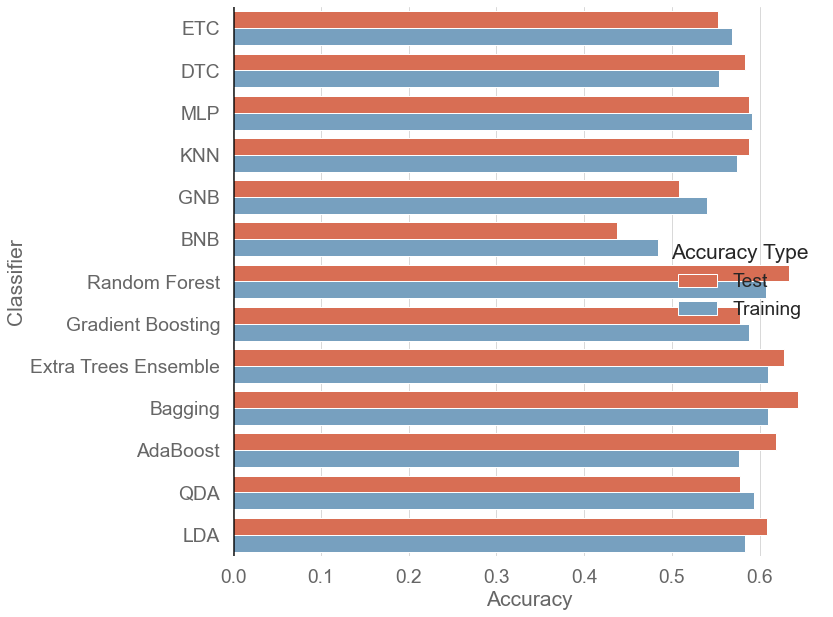

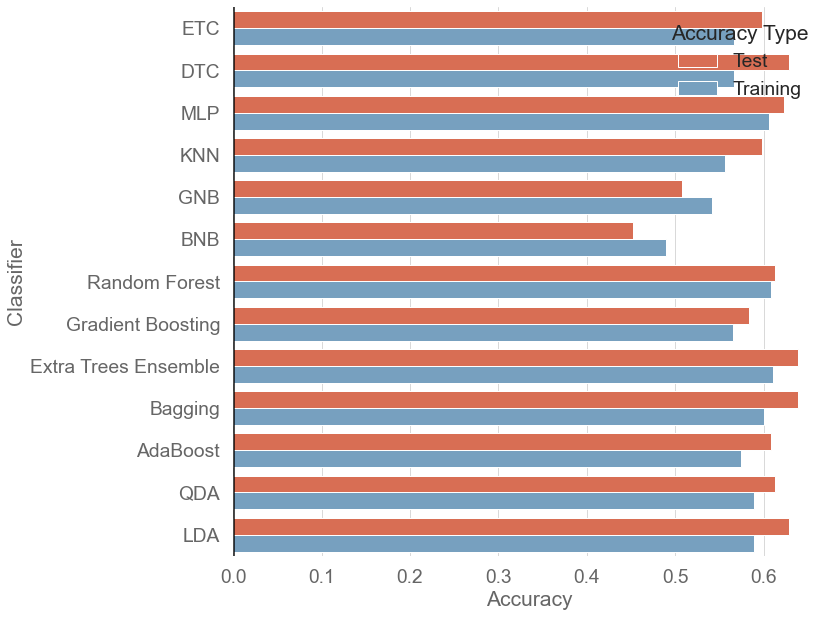

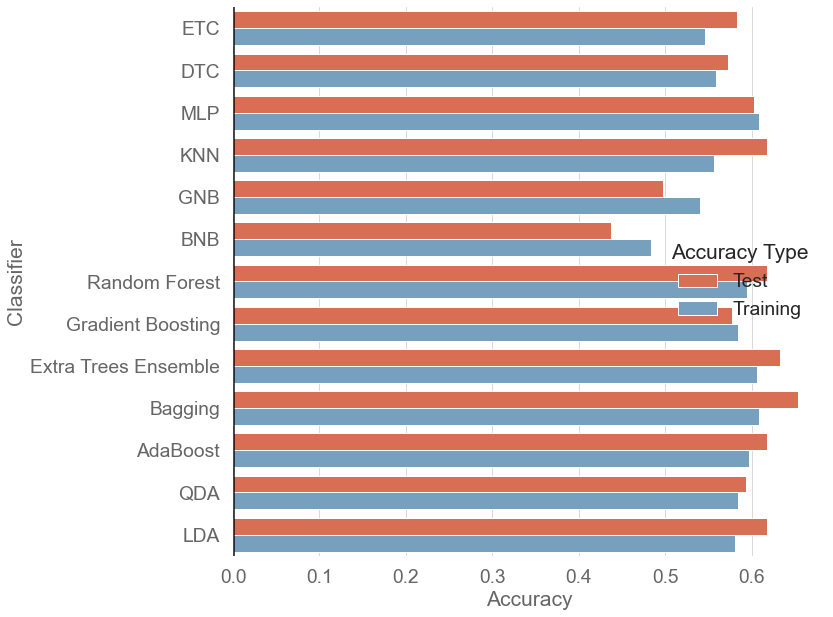

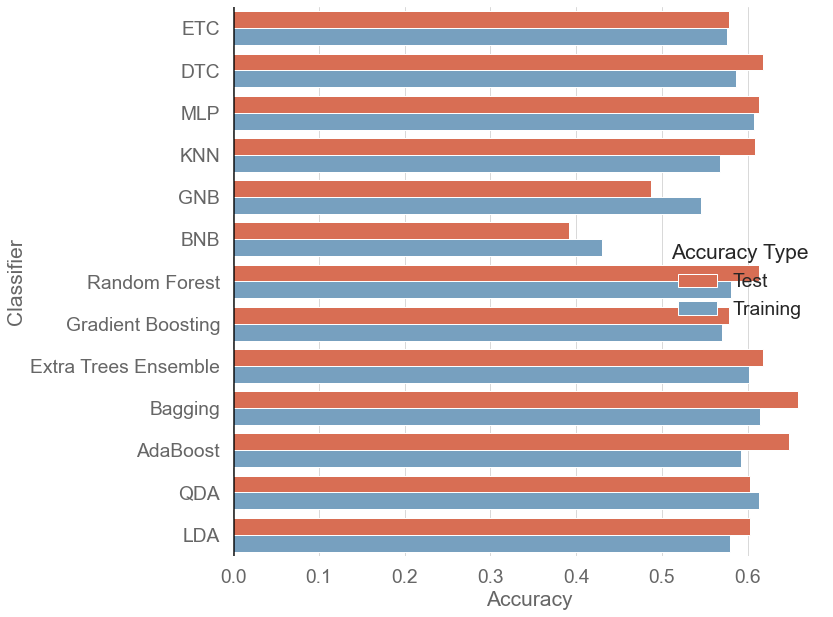

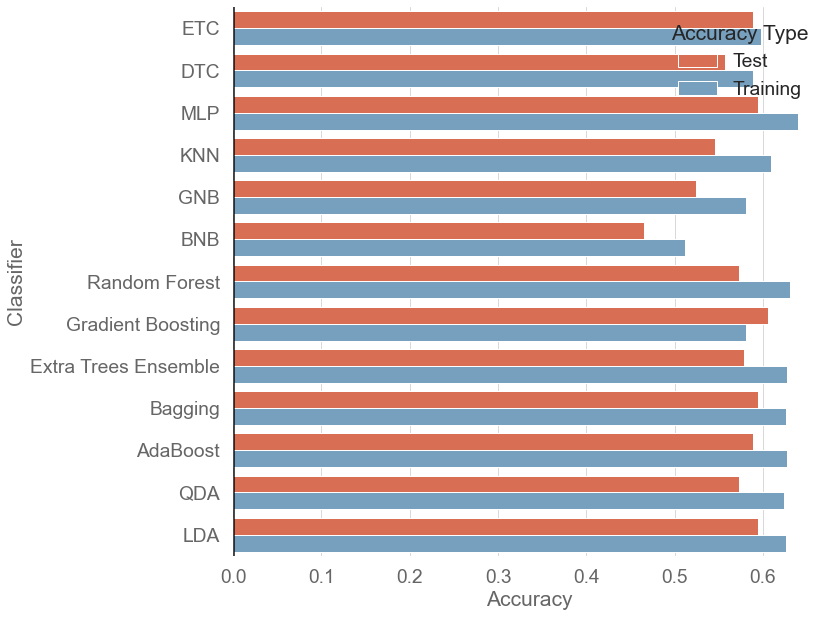

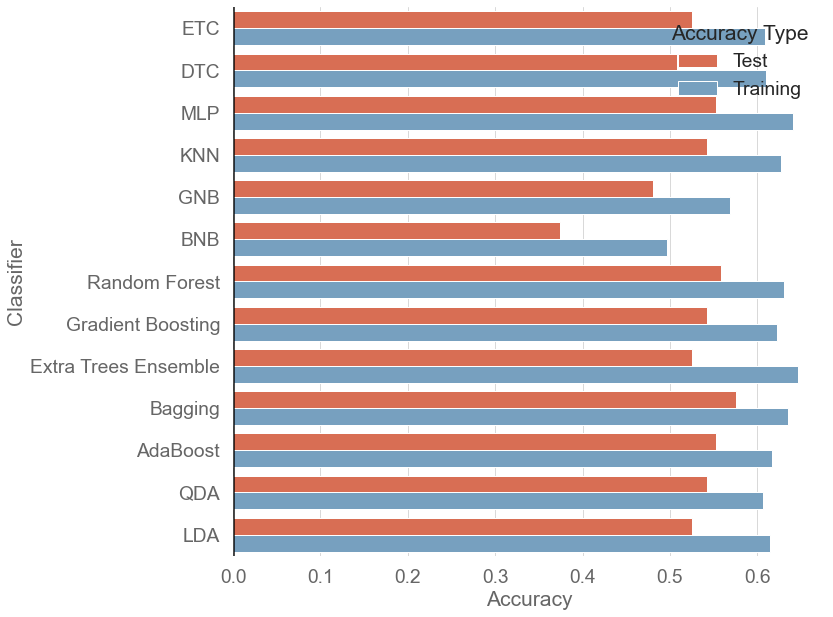

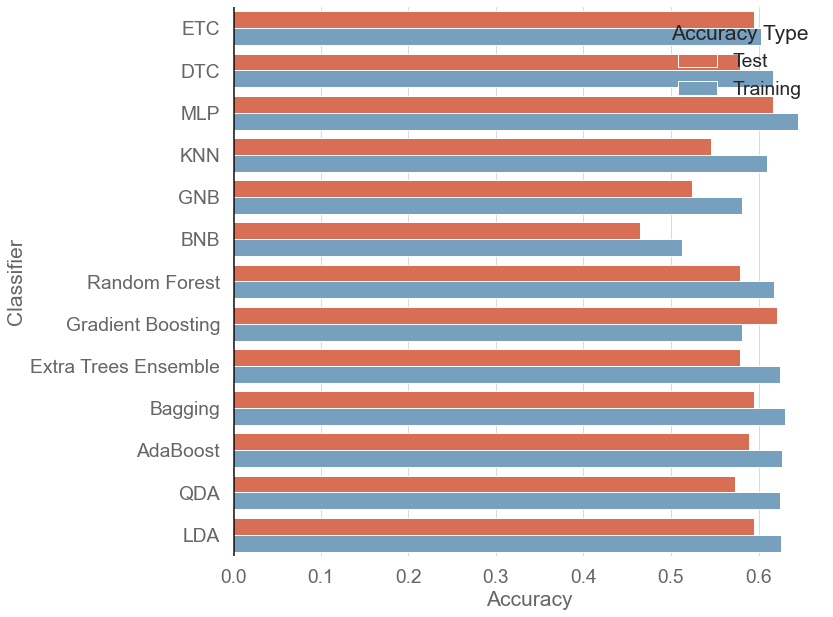

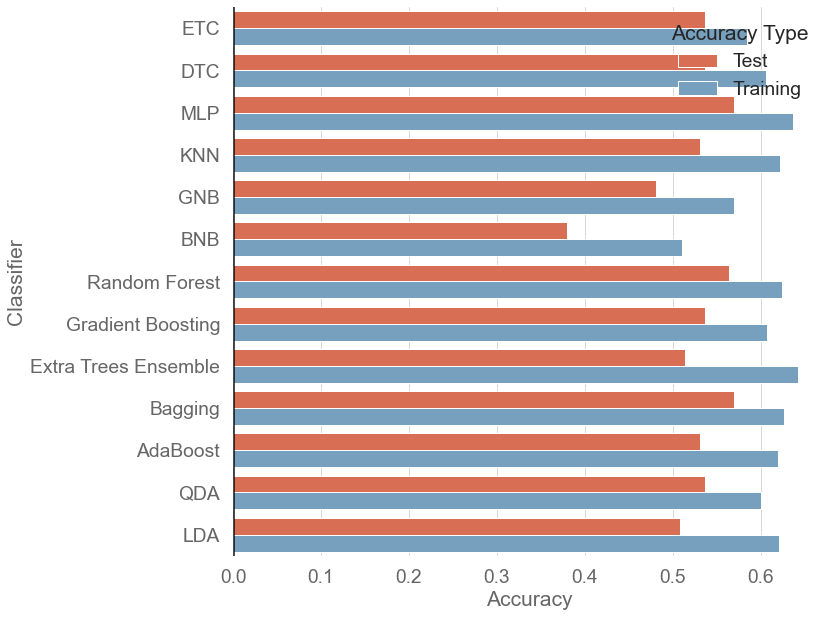

In [5]:
mfs.main('../../output/paper/FE/','../../output/paper/models/')

以下为原始方案设计时的代码，现已封装至 cfun.calV_link

## 方案1 保留原始SPEED+wifi点重新计算

In [6]:
road_all=pd.read_csv('../../output/paper/武汉路网/WUHAN_new.csv')
files=tu.getFileNames('../../output/paper/轨迹_按osmid/',postfix='.csv')
wlist=[]
for i in tqdm(range(len(files))):
    rfile=files[i]
    rname=int(rfile.split('/')[-1].split('.')[0])
    tmpTra=pd.read_csv(rfile)
    try:
        tmpTra.speed=tmpTra.apply(lambda a:a.velocity if a.type==1 else a.speed,axis=1)
        tmpTra=tu.vFilter(tmpTra,vlimt=[5, 120])
        tmpRd=road_all[road_all.osm_id==rname]
        tmpRd=tmpRd.reset_index(drop=True)
        for j in range(len(tmpRd.link_id)):
            shp = loads(tmpRd.loc[j,'geometry'])
            link_id=tmpRd.loc[j,'link_id']
            label=tmpRd.loc[j,'maxspeed']
            buf=shp.buffer(0.00001,cap_style=2)
            if not label in [20,30,40,50,60,70,80]:#暂时不考虑10、15、25
                continue
#             lon0,lat0,lon1,lat1=shp.bounds
#             tmp=tmpTra[(tmpTra.lon>=lon0)&(tmpTra.lon<lon1)&(tmpTra.lat>=lat0)&(tmpTra.lat<lat1)]
            tmp=tmpTra[tmpTra.apply(lambda x:buf.contains(Point(x['lon'], x['lat'])), axis=1)]
            if len(tmp)<=50:
                wlist.append([link_id,len(tmp)])
                continue
            tmp.to_csv(tu.pathCheck('../../output/paper/轨迹_按link_id_v0/maxspeed=%d/'%label)+'%s.csv'%link_id,index=0)
    except:
        continue
pd.DataFrame(wlist,columns=['wrong_link_id','num_of_data']).to_csv(tu.pathCheck('../../output/paper/数据质量问题路段/')+'轨迹_按link_id_v0.csv',index=0)

100%|████████████████████████████████████████████████████████████████████████████████| 1278/1278 [13:06<00:00,  1.63it/s]


## 方案2 全部重新计算

In [7]:
road_all=pd.read_csv('../../output/paper/武汉路网/WUHAN_new.csv')
files=tu.getFileNames('../../output/paper/轨迹_按osmid/',postfix='.csv')
wlist=[]
for i in tqdm(range(len(files))):
    rfile=files[i]
    rname=int(rfile.split('/')[-1].split('.')[0])
    tmpTra=pd.read_csv(rfile)
    try:
        tmpTra.speed=tmpTra.apply(lambda a:a.velocity,axis=1)
        tmpTra=tu.vFilter(tmpTra,vlimt=[5, 120])
        tmpRd=road_all[road_all.osm_id==rname]
        tmpRd=tmpRd.reset_index(drop=True)
        for j in range(len(tmpRd.link_id)):
            shp = loads(tmpRd.loc[j,'geometry'])
            link_id=tmpRd.loc[j,'link_id']
            label=tmpRd.loc[j,'maxspeed']
            buf=shp.buffer(0.00001,cap_style=2)
            if not label in [20,30,40,50,60,70,80]:#暂时不考虑10、15、25
                continue
#             lon0,lat0,lon1,lat1=shp.bounds
#             tmp=tmpTra[(tmpTra.lon>=lon0)&(tmpTra.lon<lon1)&(tmpTra.lat>=lat0)&(tmpTra.lat<lat1)]
            tmp=tmpTra[tmpTra.apply(lambda x:buf.contains(Point(x['lon'], x['lat'])), axis=1)]
            if len(tmp)<=50:
                wlist.append([link_id,len(tmp)])
                continue
            tmp.to_csv(tu.pathCheck('../../output/paper/轨迹_按link_id_v1/maxspeed=%d/'%label)+'%s.csv'%link_id,index=0)
    except:
        continue
pd.DataFrame(wlist,columns=['wrong_link_id','num_of_data']).to_csv(tu.pathCheck('../../output/paper/数据质量问题路段/')+'轨迹_按link_id_v1.csv',index=0)

100%|████████████████████████████████████████████████████████████████████████████████| 1278/1278 [12:35<00:00,  1.69it/s]


## 方案3 高acc保留，低acc利用平均

In [8]:
road_all=pd.read_csv('../../output/paper/武汉路网/WUHAN_new.csv')
files=tu.getFileNames('../../output/paper/轨迹_按osmid/',postfix='.csv')
wlist=[]
for i in tqdm(range(len(files))):
    rfile=files[i]
    rname=int(rfile.split('/')[-1].split('.')[0])
    tmpTra=pd.read_csv(rfile)
    try:
        tmpTra=tu.vFilter(tmpTra,vlimt=[5, 120])
        tmpTra=tmpTra.reset_index(drop=True)
        tmpTra=tu.genNewspeed(tmpTra)
        tmpRd=road_all[road_all.osm_id==rname]
        tmpRd=tmpRd.reset_index(drop=True)
        for j in range(len(tmpRd.link_id)):
            shp = loads(tmpRd.loc[j,'geometry'])
            link_id=tmpRd.loc[j,'link_id']
            label=tmpRd.loc[j,'maxspeed']
            buf=shp.buffer(0.00001,cap_style=2)
            if not label in [20,30,40,50,60,70,80]:#暂时不考虑10、15、25
                continue
#             lon0,lat0,lon1,lat1=shp.bounds
#             tmp=tmpTra[(tmpTra.lon>=lon0)&(tmpTra.lon<lon1)&(tmpTra.lat>=lat0)&(tmpTra.lat<lat1)]
            tmp=tmpTra[tmpTra.apply(lambda x:buf.contains(Point(x['lon'], x['lat'])), axis=1)]
            if len(tmp)<=50:
                wlist.append([link_id,len(tmp)])
                continue
            tmp.to_csv(tu.pathCheck('../../output/paper/轨迹_按link_id_v2/maxspeed=%d/'%label)+'%s.csv'%link_id,index=0)
    except:
        continue
pd.DataFrame(wlist,columns=['wrong_link_id','num_of_data']).to_csv(tu.pathCheck('../../output/paper/数据质量问题路段/')+'轨迹_按link_id_v2.csv',index=0)

100%|████████████████████████████████████████████████████████████████████████████████| 1278/1278 [12:18<00:00,  1.73it/s]


## 方案4 以轨迹段为单位

In [9]:
files0=tu.getFileNames('../../output/paper/轨迹_按link_id_v2/')
for f0 in tqdm(files0):
    files1=tu.getFileNames(f0+'/')
    for f1 in files1:
        newname=f1.replace('v2','v3')
        tu.pathCheck(newname.rsplit('/',1)[0])
        tmp=pd.read_csv(f1)
        tmp1=tmp.groupby(['fid','tid']).mean()
        tmp1.hour=tmp1.hour.apply(lambda x:int(x+0.5))
        tmp1.to_csv(newname)

100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:54<00:00,  7.83s/it]


# 最终处理方案